In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize as opt
from urbansim.models import MNLDiscreteChoiceModel

%matplotlib inline
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load model objects and saved explanatory variables

In [2]:
buildings = pd.HDFStore('expvars.h5').expvars
buildings.sqft_price_nonres = buildings.sqft_price_nonres.fillna(0)

model_coeffs = {}
for model_config in os.listdir('configs/large_area_sector'):
    submodel = MNLDiscreteChoiceModel.from_yaml(
                    str_or_buffer='configs/large_area_sector/' + model_config)
    submodel_coeffs = submodel.fit_parameters.Coefficient
    large_area = int(submodel.alts_predict_filters.split(' == ')[-1])
    sector_id = (int(model_config.split('.')[0].split('elcm')[1]) - large_area) / 100000
    model_coeffs[(large_area, sector_id)] = submodel_coeffs

### Prep data

In [3]:
buildings = buildings[buildings.non_residential_sqft > 0]
buildings['is_medical'] = buildings.building_type_id.isin([51, 52, 53]).astype('int')
buildings['is_office'] = buildings.building_type_id.isin([23, 24]).astype('int')
buildings['is_tcu'] = buildings.building_type_id.isin([33, 41, 42, 43]).astype('int')

building_cols = buildings.columns.values
sectoral_change = pd.read_csv('sectoral_change.csv').set_index('sector_id').sectoral_change

submodel_ids = [9, 4, 5, 6, 2, 
                16, 10, 17, 11, 14]

large_area_ids = [3, 5, 93, 99, 115, 125, 147, 161]

sectoral_changes = []
for submodel_id in submodel_ids:
    sectoral_changes.append(sectoral_change.loc[submodel_id])
    
x = np.transpose(buildings.as_matrix())

sectoral_changes = np.array(sectoral_changes).reshape((len(sectoral_changes), 1))
vacant_job_spaces = buildings.vacant_job_spaces.values
idx_medical = (buildings.is_medical == 1).values
idx_tcu = (buildings.is_tcu == 1).values

def get_submodel_coeffs(large_area_id):
    w = []

    for submodel_id in submodel_ids:
        coeffs = model_coeffs[(large_area_id, submodel_id)]
        if submodel_id == 14:
            coeffs = coeffs.append(pd.Series({'is_medical':0.0}))

        if submodel_id == 6:
            coeffs = coeffs.append(pd.Series({'is_tcu':0.0}))

        coeff_vals = pd.Series(0.0, index=building_cols)
        coeff_vals.loc[coeffs.index] = coeffs.values
        w.append(coeff_vals.values)

    return np.array(w)

## Summed probabilities by building type

In [4]:
def calculate_proba(w, x):
    utilities = np.dot(w, x)
    exp_utility = np.exp(utilities)

    sum_expu_across_submodels = exp_utility.sum(axis=1, keepdims=True)
    proba = exp_utility / sum_expu_across_submodels

    return proba

In [6]:
# Get ELCM coefficients for large area 3
large_area_id = 3
w = get_submodel_coeffs(large_area_id)

# Calculate probabilities
proba = np.transpose(calculate_proba(w, x))
proba_df = pd.DataFrame(proba, columns = submodel_ids)

# Sum probabilities by building type
proba_df['building_type_id'] = buildings.building_type_id.values
summed_proba_btype = proba_df.groupby('building_type_id').sum()

In [7]:
summed_proba_btype

,9,4,5,6,2,16,10,17,11,14
building_type_id,,,,,,,,,,
11,0.0896,0.0998,0.0000,0.0615,0.0486,0.0001,0.0000,0.0000,0.0600,0.0000
12,0.0079,0.0096,0.0000,0.0098,0.0091,0.0000,0.0000,0.0000,0.0088,0.0000
13,0.0289,0.0411,0.0000,0.0419,0.0470,0.0001,0.0000,0.0000,0.0485,0.0000
14,0.0260,0.0301,0.0000,0.0257,0.0310,0.0001,0.0000,0.0000,0.0363,0.0000
21,0.1600,0.1447,0.2374,0.1745,0.1361,0.0003,0.1164,0.0000,0.1386,0.0000
22,0.0313,0.0272,0.0000,0.0291,0.0306,0.0001,0.0000,0.0000,0.0282,0.0000
23,0.1719,0.1981,0.7050,0.1456,0.1568,0.9974,0.8459,1.0000,0.1735,1.0000
24,0.0119,0.0139,0.0016,0.0111,0.0120,0.0004,0.0097,0.0000,0.0132,0.0000
25,0.0237,0.0318,0.0000,0.0343,0.0272,0.0001,0.0000,0.0000,0.0255,0.0000


### Summed probabilities by building type for sector_id 6

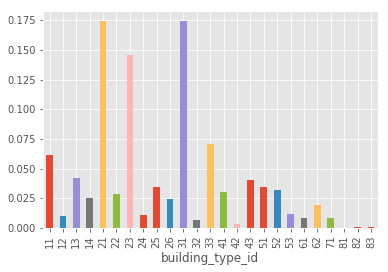

In [8]:
summed_proba_btype[6].plot.bar()

### Summed probabilities by building type for sector_id 14

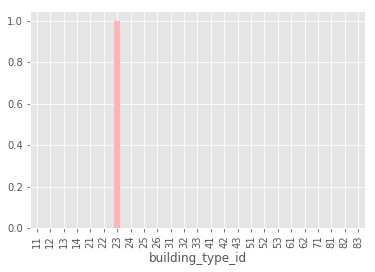

In [26]:
summed_proba_btype[14].plot.bar()

### Model coefficients for sector 6, in large area 3

In [9]:
model_coeffs[(3, 6)]

b_is_pre_1945                      -0.3132
b_ln_non_residential_sqft           0.8887
building_type_id_is_11             -0.6325
building_type_id_is_41             -0.2098
nodes_walk_ave_lot_sqft            -0.1460
nodes_walk_ave_nonres_sqft_price    0.0053
zones_employment                    0.0001
zones_ln_empden_4                  -0.7763
Name: Coefficient, dtype: float64

### Model coefficients for sector 14, in large area 3

In [8]:
model_coeffs[(3, 14)]

b_ln_building_sqft              0.3376
b_ln_land_area                  0.3192
b_total_jobs                    0.0018
bldg_empratio_14                0.0083
building_type_id_is_31          0.0221
building_type_id_is_51          0.0045
improvement_value              -0.0000
nodes_drv_log_sum_60min_jobs    0.0003
nodes_walk_medical              0.0010
zones_ln_empden_14             -0.0023
zones_logsum_job_low_income     0.0000
Name: Coefficient, dtype: float64

### Run summed probability analysis for all large areas

In [10]:
for large_area_id in large_area_ids:
    print large_area_id
    w = get_submodel_coeffs(large_area_id)
    proba = np.transpose(calculate_proba(w, x))

    proba_df = pd.DataFrame(proba, columns = submodel_ids)
    proba_df['building_type_id'] = buildings.building_type_id.values

    summed_proba_btype = proba_df.groupby('building_type_id').sum()
    print summed_proba_btype

3
                     9      4      5      6      2      16     10     17     11     14
building_type_id                                                                      
11               0.0896 0.0998 0.0000 0.0615 0.0486 0.0001 0.0000 0.0000 0.0600 0.0000
12               0.0079 0.0096 0.0000 0.0098 0.0091 0.0000 0.0000 0.0000 0.0088 0.0000
13               0.0289 0.0411 0.0000 0.0419 0.0470 0.0001 0.0000 0.0000 0.0485 0.0000
14               0.0260 0.0301 0.0000 0.0257 0.0310 0.0001 0.0000 0.0000 0.0363 0.0000
21               0.1600 0.1447 0.2374 0.1745 0.1361 0.0003 0.1164 0.0000 0.1386 0.0000
22               0.0313 0.0272 0.0000 0.0291 0.0306 0.0001 0.0000 0.0000 0.0282 0.0000
23               0.1719 0.1981 0.7050 0.1456 0.1568 0.9974 0.8459 1.0000 0.1735 1.0000
24               0.0119 0.0139 0.0016 0.0111 0.0120 0.0004 0.0097 0.0000 0.0132 0.0000
25               0.0237 0.0318 0.0000 0.0343 0.0272 0.0001 0.0000 0.0000 0.0255 0.0000
26               0.0267 0.0221 0.0560 0.0

                     9      4      5      6      2      16     10     17     11     14
building_type_id                                                                      
11               0.0198 0.0943 0.1205 0.1080 0.1046 0.0826 0.0000 0.0925 0.0000 0.0995
12               0.0020 0.0073 0.0078 0.0070 0.0061 0.0065 0.0000 0.0079 0.0000 0.0065
13               0.0024 0.0513 0.0519 0.0491 0.0351 0.0411 0.0000 0.0594 0.0000 0.0423
14               0.0075 0.0252 0.0278 0.0284 0.0221 0.0307 0.0000 0.0270 0.0000 0.0272
21               0.0466 0.1701 0.1168 0.1352 0.1391 0.1336 0.0000 0.1791 0.0000 0.1435
22               0.0016 0.0340 0.0307 0.0254 0.0205 0.0245 0.0000 0.0322 0.0000 0.0253
23               0.1839 0.1290 0.1116 0.1644 0.2532 0.2079 0.9999 0.1191 0.9995 0.1494
24               0.1448 0.0111 0.0109 0.0127 0.0086 0.0197 0.0000 0.0109 0.0000 0.0117
25               0.0220 0.0126 0.0056 0.0255 0.0076 0.0289 0.0000 0.0284 0.0000 0.0305
26               0.0091 0.0210 0.0165 0.017

## Summed capacity-weighted probabilities by building type

In [12]:
def capacity_weighted_proba(w, x, alt_capacity):
    proba = calculate_proba(w, x)
    capacity_weighted_proba = proba * alt_capacity
    sum_capac_wproba_across_submodels = capacity_weighted_proba.sum(axis=1, keepdims=True)
    capacity_weighted_proba_normalized = capacity_weighted_proba / sum_capac_wproba_across_submodels
    
    return capacity_weighted_proba_normalized

In [27]:
large_area_id = 3
w = get_submodel_coeffs(large_area_id)
capac_weighted_proba = np.transpose(capacity_weighted_proba(w, x, vacant_job_spaces))

proba_df = pd.DataFrame(capac_weighted_proba, columns=submodel_ids)
proba_df['building_type_id'] = buildings.building_type_id.values

summed_capac_weighted_proba_btype = proba_df.groupby('building_type_id').sum()

In [28]:
summed_capac_weighted_proba_btype

,9,4,5,6,2,16,10,17,11,14
building_type_id,,,,,,,,,,
11,0.0324,0.0722,0.0000,0.0152,0.0136,0.0000,0.0000,0.0000,0.0160,0.0000
12,0.0013,0.0033,0.0000,0.0010,0.0017,0.0000,0.0000,0.0000,0.0024,0.0000
13,0.0006,0.0019,0.0000,0.0007,0.0007,0.0000,0.0000,0.0000,0.0006,0.0000
14,0.0162,0.0326,0.0000,0.0124,0.0183,0.0000,0.0000,0.0000,0.0249,0.0000
21,0.0308,0.0467,0.0051,0.0302,0.0216,0.0000,0.0020,0.0000,0.0218,0.0000
22,0.0056,0.0105,0.0000,0.0050,0.0041,0.0000,0.0000,0.0000,0.0032,0.0000
23,0.3849,0.3384,0.9842,0.4220,0.4080,0.9999,0.9857,1.0000,0.4215,1.0000
24,0.0141,0.0264,0.0018,0.0130,0.0166,0.0000,0.0088,0.0000,0.0209,0.0000
25,0.0057,0.0316,0.0000,0.0057,0.0122,0.0000,0.0000,0.0000,0.0126,0.0000


### Summed capacity-weighted probabilities by building type for sector_id 6

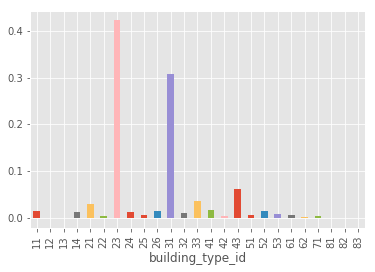

In [29]:
summed_capac_weighted_proba_btype[6].plot.bar()

### Summed capacity-weighted probabilities by building type for sector_id 14

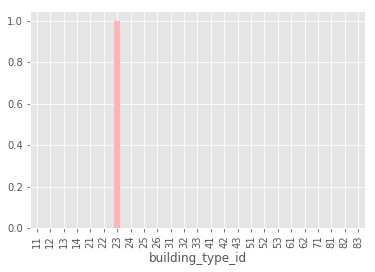

In [30]:
summed_capac_weighted_proba_btype[14].plot.bar()

### Run summed capacity-weighted probability analysis for all large areas

In [13]:
for large_area_id in large_area_ids:
    print large_area_id
    w = get_submodel_coeffs(large_area_id)
    capac_weighted_proba = np.transpose(capacity_weighted_proba(w, x, vacant_job_spaces))

    proba_df = pd.DataFrame(capac_weighted_proba, columns=submodel_ids)
    proba_df['building_type_id'] = buildings.building_type_id.values

    summed_capac_weighted_proba_btype = proba_df.groupby('building_type_id').sum()
    print summed_capac_weighted_proba_btype
    print''

3
                      9       4       5       6       2       16      10      17      11      14
building_type_id                                                                                
11                0.0324  0.0722  0.0000  0.0152  0.0136  0.0000  0.0000  0.0000  0.0160  0.0000
12                0.0013  0.0033  0.0000  0.0010  0.0017  0.0000  0.0000  0.0000  0.0024  0.0000
13                0.0006  0.0019  0.0000  0.0007  0.0007  0.0000  0.0000  0.0000  0.0006  0.0000
14                0.0162  0.0326  0.0000  0.0124  0.0183  0.0000  0.0000  0.0000  0.0249  0.0000
21                0.0308  0.0467  0.0051  0.0302  0.0216  0.0000  0.0020  0.0000  0.0218  0.0000
22                0.0056  0.0105  0.0000  0.0050  0.0041  0.0000  0.0000  0.0000  0.0032  0.0000
23                0.3849  0.3384  0.9842  0.4220  0.4080  0.9999  0.9857  1.0000  0.4215  1.0000
24                0.0141  0.0264  0.0018  0.0130  0.0166  0.0000  0.0088  0.0000  0.0209  0.0000
25                0.0057  0.

                      9       4       5       6       2       16      10      17      11      14
building_type_id                                                                                
11                0.0281  0.0000  0.0285  0.0234  0.0223  0.0320  0.0000  0.0323  0.0232  0.0299
12                0.0012  0.0000  0.0015  0.0008  0.0009  0.0013  0.0000  0.0009  0.0008  0.0014
13                0.0006  0.0000  0.0007  0.0005  0.0005  0.0008  0.0000  0.0005  0.0005  0.0003
14                0.0243  0.0000  0.0167  0.0114  0.0126  0.0167  0.0000  0.0119  0.0150  0.0153
21                0.0276  0.0000  0.0228  0.0302  0.0240  0.0323  0.0000  0.0234  0.0225  0.0229
22                0.0039  0.0000  0.0041  0.0039  0.0030  0.0053  0.0000  0.0056  0.0033  0.0043
23                0.5109  0.9999  0.3550  0.3207  0.4532  0.4160  1.0000  0.3415  0.5513  0.6626
24                0.0296  0.0000  0.0170  0.0131  0.0110  0.0161  0.0000  0.0196  0.0333  0.0062
25                0.0100  0.00

## What building type dummy coefficient value may result in closer fit between simulated / observed sector shares by building type

In [15]:
# Objective function to minimize

def growth_share_deviation(coeff, w, x, obs_growth, idx_alts, growth_share_target, submodel_idx, coeff_idx, alt_capacity):
    w[submodel_idx, coeff_idx] = coeff
    capacity_weighted_proba_normalized = capacity_weighted_proba(w, x, alt_capacity)
    expected_growth = np.transpose(capacity_weighted_proba_normalized * obs_growth)
    
    alts_of_interest = expected_growth[idx_alts]
    growth_shares_by_submodel = alts_of_interest.sum(axis=0) / alts_of_interest.sum()
    abs_deviation = abs(growth_shares_by_submodel[submodel_idx] - growth_share_target)
    
    return abs_deviation

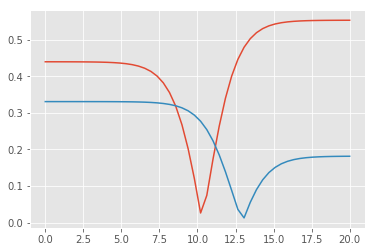

In [16]:
w = get_submodel_coeffs(99)

coeffs = np.linspace(0, 20, 50)
errors = [growth_share_deviation(coeff, w, x, sectoral_changes, idx_medical, .44, -1, -3, vacant_job_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

coeffs = np.linspace(0, 20, 50)
errors = [growth_share_deviation(coeff, w, x, sectoral_changes, idx_tcu, .331, 3, -1, vacant_job_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

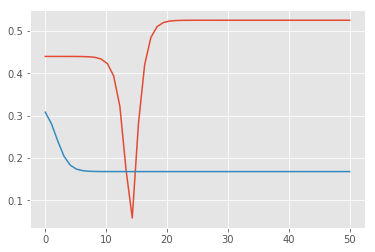

In [18]:
w = get_submodel_coeffs(3)

coeffs = np.linspace(0, 50, 50)
errors = [growth_share_deviation(coeff, w, x, sectoral_changes, idx_medical, .44, -1, -3, vacant_job_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

coeffs = np.linspace(0, 50, 50)
errors = [growth_share_deviation(coeff, w, x, sectoral_changes, idx_tcu, .331, 3, -1, vacant_job_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

In [19]:
for large_area_id in large_area_ids:
    print large_area_id
    w = get_submodel_coeffs(large_area_id)

    result = opt.minimize_scalar(growth_share_deviation, method='Brent', args=(w, x, sectoral_changes, idx_medical, .44, -1, -3, vacant_job_spaces))
    print result.x

    result = opt.minimize_scalar(growth_share_deviation, method='Brent', args=(w, x, sectoral_changes, idx_tcu, .331, 3, -1, vacant_job_spaces))
    print result.x

    print ''

3
14.044541474594123
42.64975064646236

5
0.4477708975410058
80.97655765647947

93
2.6180339603380443
38.86715127045852

99
10.311974475471855
12.95048899057403

115
2.6180339603380443
61.503808853077395

125
-0.04907031384132896
41.10695984053627

147
0.11493397809828242
41.39762057301232

161
0.5205068926928321
83.07764609487715



## Suggested next steps

X Turning off relocation

- * Sample small number of alts in ELCM/HLCM, instead of no-sampling

- * Region-wide estimation for ELCM/HLCM.  Still simulate by large area, but use the regionally-estimated coefficients.   Regionally by sector.   Regionally by income quartile.


###################################################################
- Re-specify models with a greater focus on building type specifically (cross-sectional)

- Utility / probability analysis for submodels where summed probabilities overwhelmingly belong to one building type

- Try for better coefficient values by using different settings in estimation.  Try the non-convergence PR.  With and without regularization

- Paul's diffusion research:  sample fewer alternatives, try alternative samplers.   

- Calibrated building type dummies to base-year btype shares (longitudinal data) 